# Modeling for Football Data from Transfermarkt
- Kaggle Data URL

    - https://www.kaggle.com/datasets/davidcariboo/player-scores

## 데이터 설명
- Transfermarkt 웹사이트에서 스크레이핑한 각종 축구 데이터 (매주 한번 파일 업데이트)
    - 주요 대회 시즌별 60,000개 이상의 경기
    - 모든 대회의 400개 이상의 클럽들
    - 30,000 이상의 선수들
    - 400,000개 이상의 선수 가치 기록
    - 1,200,000개 이상의 선수 출전 기록

- `csv` 파일 설명
    - `apperances` : 선수 출장 기록
    - `club_games` : 클럽별 경기 홈팀, 어웨이팀 정보
    - `clubs` : 리그별 속해 있는 클럽
    - `competitions` : 대회 정보
    - `game_events` : 경기별 이벤트 정보 (카드, 득점, 어시스트 등)
    - `game_lineups` : 경기별 선수의 선발, 교체 명단 등재 여부
    - `games` : 경기에 대한 정보 (시즌, 라운드, 홈팀, 어웨이팀, 순위)
    - `player_valuations` : Transfermarkt 웹사이트에서 매긴 선수의 가치
    - `players` : 선수에 대한 세부 정보

- 데이터베이스 스키마
    <img src="https://raw.githubusercontent.com/dcaribou/transfermarkt-datasets/master/resources/diagram.svg?sanitize=true" width="1700">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import TargetEncoder

from xgboost import plot_importance

import shap

import warnings
warnings.filterwarnings(action='ignore')

c:\Users\aryij\anaconda3\envs\football\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 데이터 경로
path = "data/df_eda.csv"
df = pd.read_csv(path)

In [3]:
df.head()

,player_name,start_season,goals,assists,minutes_played,competition_code,date_of_birth,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
0,Aaron Connolly,2019,3,2,1261,premier-league,2000-01-28,20,Centre-Forward,Brighton and Hove Albion Football Club,4000000.0,Ireland,right,174.0
1,Aaron Connolly,2020,2,1,791,premier-league,2000-01-28,21,Centre-Forward,Brighton and Hove Albion Football Club,7000000.0,Ireland,right,174.0
2,Aaron Connolly,2021,0,0,155,premier-league,2000-01-28,22,Centre-Forward,Brighton and Hove Albion Football Club,6000000.0,Ireland,right,174.0
3,Aaron Cresswell,2019,3,0,2730,premier-league,1989-12-15,30,Left-Back,West Ham United Football Club,6500000.0,England,left,170.0
4,Aaron Cresswell,2020,0,8,3172,premier-league,1989-12-15,31,Left-Back,West Ham United Football Club,5000000.0,England,left,170.0


In [4]:
# date_of_birth 열 제거 (age로 대체)
df = df.drop("date_of_birth", axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16001 entries, 0 to 16000
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              16001 non-null  object 
 1   start_season             16001 non-null  int64  
 2   goals                    16001 non-null  int64  
 3   assists                  16001 non-null  int64  
 4   minutes_played           16001 non-null  int64  
 5   competition_code         16001 non-null  object 
 6   age                      16001 non-null  int64  
 7   position                 16001 non-null  object 
 8   current_club_name        16001 non-null  object 
 9   market_value_per_season  16001 non-null  float64
 10  country                  16001 non-null  object 
 11  foot                     16001 non-null  object 
 12  height_in_cm             16001 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 1.6+ MB


In [6]:
# 수치형, 범주형 변수 따로 선언
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

In [7]:
print("수치형 변수 :", num_cols)
print("범주형 변수 :", cat_cols)

수치형 변수 : ['start_season', 'goals', 'assists', 'minutes_played', 'age', 'market_value_per_season', 'height_in_cm']
범주형 변수 : ['player_name', 'competition_code', 'position', 'current_club_name', 'country', 'foot']


## 데이터 분리

In [8]:
# target 컬럼 "market_value_per_season"
target = "market_value_per_season"
# 나머지 컬럼 features에 선언
features = df.drop(columns=target).columns

# 학습할 train 데이터 : 19-20 ~ 22-23 시즌 데이터 (4시즌)
train = df[df.start_season != 2023]
# 예측할 test 데이터 : 23-24 시즌 데이터
test = df[df.start_season == 2023]

train.shape, test.shape

((13081, 13), (2920, 13))

In [9]:
# validation 데이터셋 생성
train, val = train_test_split(train, train_size=0.8, random_state=42)

In [10]:
# train 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((10464, 12), (10464,), (2617, 12), (2617,), (2920, 12), (2920,))

In [11]:
num_cols = df.drop(columns=target).select_dtypes(include=np.number).columns.tolist()

# train 데이터 copy
X_train_no_enc = train[features].copy()
# y_train_no_enc = train[target].copy()

# validation 데이터 copy
X_val_no_enc = val[features].copy()
# y_val_no_enc = val[target].copy()

# test 데이터 copy
X_test_no_enc = test[features].copy()
# y_test_no_enc = test[target].copy()

## 인코딩

### Target Encoding
- 머신 러닝 모델의 출력이 숫자 (회귀)일 때만 범주형 feature에 사용

- 각 범주에 대한 평균 목표값 계산 → 인코딩 하기 위해 범주형 값이 갖는 범주에 해당하는 백분율 대체
- 각 카테고리의 값을 학습 데이터의 target 값의 평균값으로 설정한다
- 데이터 관측치가 많아야 한다
- 과적합의 원인이 될 수 있다
- references
    - https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%9D%BC%EA%B3%B1%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-7a40e7de39d4
    - https://velog.io/@seungwoong12/encoding

In [12]:
# Scikit-learn TargetEncoder 사용
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html
# Scikit-learn 버전 높아야 사용 가능 (업데이트 필요)

# 범주형 변수 목록 cat_features에 선언
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()

# smooth="auto", cv=5로 TargetEncoder 객체 생성
te = TargetEncoder(target_type="continuous", smooth="auto", cv=5)

for cat_feature in cat_features:
    # Train 데이터로 fit_transform 해준다
    X_train[[cat_feature]] = te.fit_transform(X_train[[cat_feature]], y_train)
    X_val[[cat_feature]] = te.transform(X_val[[cat_feature]])
    X_test[[cat_feature]] = te.transform(X_test[[cat_feature]])

## 회귀모델 평가 지표
- `R2 Score` (결정 계수)
    - 종속 변수의 총 변동 중 모델이 설명하는 변동의 비율
    - 0 ~ 1 사이의 값을 가지며, 높을 수록 모델이 데이터를 잘 설명한다는 뜻
    
- `RMSLE`
    - MSE에 루트를 씌운 RMSE의 각 인자에 로그를 취해준 값
        - 로그 변환을 통해 이상치에 대한 영향을 줄이고, 모델이 이상치에 대해 과도하게 페널티를 받지 않게 한다
        - 과소평가된 항목에 큰 패널티를 부여한다
        - 상대적 ERROR 측정
        - 값의 범위가 넓은 데이터에서 이상치에 대해 변화의 폭이 크지 않다
    - 정규 분포를 따르지 않고 불균형한 모형일 때 사용되는 방법

- 평가 지표 선정 이유
    - 예측하고자 하는 타겟에 이상치가 많이 존재한다 (`market_value_per_season`)
        - `R2 Score` : 모델이 얼마나 데이터의 변동을 잘 설명하는지 평가
        - `RMSLE` : 이상치에 강건한 특성을 갖는다
            - 실제보다 작게 예측이 되었을 때 페널티를 더 크게 부여한다
            - 선수 몸값이 실제 몸값 보다 적게 측정된다면, 
                - Transfermarkt 웹사이트가 몸값을 부풀린다고 오해받을 수 있다 
                - 실제 이적시장에 거품이 많이 끼어있다고 생각할 수도 있다
            - 따라서 과소 평가 항목에 페널티를 주는 `RMSLE`를 통해 평가

- References
    - https://shinminyong.tistory.com/32
    - https://wikidocs.net/219419
    - https://www.inflearn.com/questions/992421/rmsle%EC%9D%98-%EC%82%AC%EC%9A%A9%EC%97%90-%EA%B4%80%ED%95%9C-%EC%A7%88%EB%AC%B8%EC%9E%85%EB%8B%88%EB%8B%A4

In [13]:
def get_rmsle(y_actual, y_pred):
    # sklearn의 mean_square_log_error 함수는 y_pred 값 중 하나라도 0 미만인 경우 에러 발생
    # y_pred + 1 만들어 0보다 크게 만들어 준다 (음수가 되지 않게 방지)
    # 이후 optuna에 적용하여 RMSLE를 기준으로 하이퍼파라미터 튜닝
    
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()                 
    return np.sqrt(mean_error)   

In [14]:
# def rmsle(y, pred):
#     log_y = np.log1p(y)
#     log_pred = np.log1p(pred)
#     squared_error = (log_y-log_pred)**2
#     rmsle = np.sqrt(np.mean(squared_error))
#     return rmsle

## Baseline 모델 생성

In [15]:
# https://medium.com/machine-learning-with-python/multiple-linear-regression-implementation-in-python-2de9b303fc0c

In [16]:
# 선형회귀 모델로 Baseline 모델 생성
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [17]:
# Baseline 모델 절편, 결정 계수 확인

print("Intercept: ", lr.intercept_)
print("Coefficients:")
list(zip(X_train, lr.coef_))

Intercept:  300696121.8608369
Coefficients:


[('player_name', 0.6171582986364859),
 ('start_season', -149658.21288998143),
 ('goals', 690847.0185452163),
 ('assists', 606745.8839550889),
 ('minutes_played', 1762.9393387659131),
 ('competition_code', 0.19445530523444177),
 ('age', -274311.2724154061),
 ('position', 0.0956108777704685),
 ('current_club_name', 0.37581780570326373),
 ('country', 0.01928086242878635),
 ('foot', -0.47635897641637115),
 ('height_in_cm', 31133.351114944348)]

In [18]:
def baseline_model(model_name, model):
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")
    
    # 모델 생성 및 훈련
    # model.fit(X_train, y_train)

    # Baseline 모델로 train, validation, test 데이터셋 예측
    y_train_pred_lr = model.predict(X_train)
    y_val_pred_lr = model.predict(X_val)
    y_test_pred_lr = model.predict(X_test)

    # Baseline 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
    base_meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred_lr)
    base_meanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr)
    base_rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr, squared=False)
    base_rootMeanSqLogErr = get_rmsle(y_test, y_test_pred_lr)


    # 결과를 리스트에 저장
    baseline_results.append({"Model" : model_name,
                             "MAE" : '{:.2f}'.format(base_meanAbErr),
                             "MSE" : '{:.2f}'.format(base_meanSqErr),
                             "RMSE" : '{:.2f}'.format(base_rootMeanSqErr),
                             "RMSLE" : '{:.2f}'.format(base_rootMeanSqLogErr),
                             "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)
    
    return baseline_df

In [19]:
baseline_model("Linear Regression", lr)


====== Baseline Model : Linear Regression ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Linear Regression,5368313.54,94190318845380.34,9705169.70,0.97,0.65


## 스케일링
- 데이터셋의 다양한 컬럼들에 이상치 다수 존재
    - 하지만 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라진다
    - 따라서 이상치 제거하지 않음
- `RobustScaler` 선택 (이상치의 영향 최소화)
- References
    - https://cheris8.github.io/data%20analysis/DP-Data-Scaling/

### `RobustScaling`
- 데이터의 중앙값 = 0, IQE = 1이 되도록 스케일링
    - IQR = Q3 - Q1 : 25퍼센타일과 75퍼센타일의 값들
- 중앙값 (Median)과 IQR (Interquartile Range) 사용
    - `RobustScaler`를 사용할 경우, `StandardScaler`에 비해 스케일링 결과가 더 넓게 분포
- 모든 feature들이 같은 스케일을 갖는다
- 이상치의 영향을 최소화 한다

In [20]:
# # RobustScaler X_train 데이터셋에 fit
# robustScaler = RobustScaler().fit(X_train)

# # RobustScaler로 X_train, X_val, X_test 데이터셋 변환
# X_train_robust = robustScaler.transform(X_train)
# X_val_robust = robustScaler.transform(X_val)
# X_test_robust = robustScaler.transform(X_test)

## 머신러닝 모델링

### 하이퍼 파라미터 튜닝 전 모델 생성

In [21]:
model_list = ["lr_model", "dt_model", "rf_model", "cat_model", "lgbm_model", "xgb_model"]

lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

In [22]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

In [23]:
def model_list(models, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)

        # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
        meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred)
        meanSqErr = metrics.mean_squared_error(y_test, y_test_pred)
        rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
        rootMeanSqLogErr = get_rmsle(y_test, y_test_pred)


        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                                "MAE" : '{:.2f}'.format(meanAbErr),
                                "MSE" : '{:.2f}'.format(meanSqErr),
                                "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr),
                                "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSLE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [24]:
# Top 3 : Random Forest, LightGBM, CatBoost, XGBoost순으로 RMSLE 높다
model_list(models)

Learning rate set to 0.059332
0:	learn: 13546845.4703072	total: 141ms	remaining: 2m 20s
1:	learn: 13066547.2749380	total: 143ms	remaining: 1m 11s
2:	learn: 12623866.5670312	total: 146ms	remaining: 48.5s
3:	learn: 12188722.3957981	total: 148ms	remaining: 36.9s
4:	learn: 11798840.7161257	total: 151ms	remaining: 30s
5:	learn: 11413765.9910732	total: 153ms	remaining: 25.3s
6:	learn: 11068276.5686400	total: 155ms	remaining: 22s
7:	learn: 10746685.4581941	total: 158ms	remaining: 19.5s
8:	learn: 10432461.9564100	total: 160ms	remaining: 17.6s
9:	learn: 10147678.0102176	total: 162ms	remaining: 16.1s
10:	learn: 9890999.7836099	total: 165ms	remaining: 14.8s
11:	learn: 9646425.4817173	total: 167ms	remaining: 13.7s
12:	learn: 9409531.7130938	total: 169ms	remaining: 12.9s
13:	learn: 9191199.9674395	total: 172ms	remaining: 12.1s
14:	learn: 9000424.6475469	total: 174ms	remaining: 11.4s
15:	learn: 8827728.0597172	total: 176ms	remaining: 10.8s
16:	learn: 8646791.6810889	total: 179ms	remaining: 10.3s
17:

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Random Forest,4229621.40,84317742769520.55,9182469.32,0.65,0.69
1,LightGBM,4055145.77,72932189795189.78,8540034.53,0.69,0.73
2,CatBoost,4001964.44,70401169915538.80,8390540.50,0.72,0.74
3,XGBoost,4214087.32,80370723897698.52,8964972.05,0.73,0.70
4,Decision Tree,5472285.96,123178182577054.80,11098566.69,0.91,0.55
5,Linear Regression,5368313.54,94190318845380.34,9705169.70,0.97,0.65


In [25]:
# 범주형 변수를 따로 Target Encoding 거치지 않은 데이터셋으로 학습한 CatBoost 확인
def model_list2(models):
    models_results = []

    for model_name, model in models:

        if model_name == "CatBoost":

            cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

            # 모델 생성 및 훈련
            model.fit(X_train_no_enc, y_train, cat_features=cat_features)

            # Robust Scaling 거치지 않은 train 데이터를 바탕으로 예측
            y_train_pred_cat = model.predict(X_train_no_enc)
            y_val_pred_cat = model.predict(X_val_no_enc)
            y_test_pred_cat = model.predict(X_test_no_enc)

            # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
            meanAbErr_cat = metrics.mean_absolute_error(y_test, y_test_pred_cat)
            meanSqErr_cat = metrics.mean_squared_error(y_test, y_test_pred_cat)
            rootMeanSqErr_cat = metrics.mean_squared_error(y_test, y_test_pred_cat, squared=False)
            rootMeanSqLogErr_cat = get_rmsle(y_test, y_test_pred_cat)

            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr_cat),
                                    "MSE" : '{:.2f}'.format(meanSqErr_cat),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr_cat),
                                    "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr_cat),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_test_no_enc, y_test))})
        
        else:
            
            # 모델 생성 및 훈련
            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
            y_test_pred = model.predict(X_test)

            # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
            meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred)
            meanSqErr = metrics.mean_squared_error(y_test, y_test_pred)
            rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
            rootMeanSqLogErr = get_rmsle(y_test, y_test_pred)


            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr),
                                    "MSE" : '{:.2f}'.format(meanSqErr),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                    "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models before Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSLE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [26]:
model_list2(models)

Learning rate set to 0.059332
0:	learn: 13653696.6051392	total: 66.2ms	remaining: 1m 6s
1:	learn: 13289911.9578542	total: 141ms	remaining: 1m 10s
2:	learn: 12974497.2540124	total: 218ms	remaining: 1m 12s
3:	learn: 12664524.7075041	total: 297ms	remaining: 1m 14s
4:	learn: 12381771.8118006	total: 397ms	remaining: 1m 18s
5:	learn: 12110808.3301324	total: 481ms	remaining: 1m 19s
6:	learn: 11857426.9500235	total: 572ms	remaining: 1m 21s
7:	learn: 11614183.0093664	total: 647ms	remaining: 1m 20s
8:	learn: 11410700.5592546	total: 723ms	remaining: 1m 19s
9:	learn: 11187253.5307023	total: 799ms	remaining: 1m 19s
10:	learn: 10977126.3796601	total: 874ms	remaining: 1m 18s
11:	learn: 10794053.4259314	total: 953ms	remaining: 1m 18s
12:	learn: 10632607.2516437	total: 1.03s	remaining: 1m 18s
13:	learn: 10463427.2507392	total: 1.1s	remaining: 1m 17s
14:	learn: 10314079.3497962	total: 1.18s	remaining: 1m 17s
15:	learn: 10166125.8591156	total: 1.26s	remaining: 1m 17s
16:	learn: 10041279.0114318	total: 1.

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Random Forest,4229621.40,84317742769520.55,9182469.32,0.65,0.69
1,LightGBM,4055145.77,72932189795189.78,8540034.53,0.69,0.73
2,XGBoost,4214087.32,80370723897698.52,8964972.05,0.73,0.70
3,CatBoost,4599038.41,85747317567412.42,9259984.75,0.84,0.68
4,Decision Tree,5472285.96,123178182577054.80,11098566.69,0.91,0.55
5,Linear Regression,5368313.54,94190318845380.34,9705169.70,0.97,0.65


#### `CatBoost` 성능 비교
- 별도로 `Target Encoding` 거친 데이터셋으로 진행(`model_list` 함수)한 `CatBoost`가 더 낮은 `RMSLE` 기록

    - **0.73 vs 0.84** (Target Encoding 실행한 데이터셋으로 진행)

### 하이퍼 파라미터 튜닝
- `RMSLE`가 높은 `Random Forest`, `CatBoost`, `LightGBM`, `XGBoost` 을 갖고 하이퍼 파라미터 튜닝
    - Baseline 모델인 `Linear Regression`의 `RMSLE`보다 낮다 (0.98)

- `optuna` 활용
    - References : https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/


In [27]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

#### `Random Forest`

In [28]:
def objective_rf(trial):
    params = {
        # "iterations": 1000,
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        # "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "max_samples": trial.suggest_float("max_samples", 0.05, 1.0),
        "max_features": trial.suggest_float("max_features", 0.05, 1.0),
        "min_weight_fraction_leaf": trial.suggest_int("min_weight_fraction_leaf", 0.05, 0.5),
    }

    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmsle = get_rmsle(y_test, predictions)

    return rmsle

In [29]:
study_rf = optuna.create_study(direction='minimize', sampler=sampler)
study_rf.optimize(objective_rf, n_trials=30)

[I 2024-04-03 14:03:03,436] A new study created in memory with name: no-name-e8806743-8b25-44e3-9bfd-1cdda7b532c1
[I 2024-04-03 14:03:34,075] Trial 0 finished with value: 0.6927821000758467 and parameters: {'n_estimators': 1811, 'max_depth': 10, 'max_samples': 0.7453942447208348, 'max_features': 0.6187255599871848, 'min_weight_fraction_leaf': 0}. Best is trial 0 with value: 0.6927821000758467.
[I 2024-04-03 14:03:36,123] Trial 1 finished with value: 1.154096571495204 and parameters: {'n_estimators': 1046, 'max_depth': 2, 'max_samples': 0.10517943155978948, 'max_features': 0.8728673384861885, 'min_weight_fraction_leaf': 0}. Best is trial 0 with value: 0.6927821000758467.
[I 2024-04-03 14:03:46,376] Trial 2 finished with value: 0.7675071900397695 and parameters: {'n_estimators': 2604, 'max_depth': 8, 'max_samples': 0.06955526958101232, 'max_features': 0.9714143595538947, 'min_weight_fraction_leaf': 0}. Best is trial 0 with value: 0.6927821000758467.
[I 2024-04-03 14:03:52,099] Trial 3 fi

In [30]:
print("Best hyperparameters:", study_rf.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_rf.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 631, 'max_depth': 10, 'max_samples': 0.997411579172022, 'max_features': 0.7757097812551539, 'min_weight_fraction_leaf': 0}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.6890031657594216


In [31]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_rf)

In [32]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_rf)

In [33]:
rf_optuna = RandomForestRegressor(**study_rf.best_params)
model_list([("RandomForest_tuned", rf_optuna)], "After")


====== Models After Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,RandomForest_tuned,4331434.65,86527059494929.47,9301992.23,0.69,0.68


#### `CatBoost`

In [34]:
def objective_cat(trial):
    params = {
        # "iterations": 1000,
        "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmsle = get_rmsle(y_test, predictions)

    return rmsle

In [35]:
study_cat = optuna.create_study(direction='minimize', sampler=sampler)
study_cat.optimize(objective_cat, n_trials=30)

[I 2024-04-03 14:11:33,396] A new study created in memory with name: no-name-e1966ff5-a98b-44d8-bde5-49e424f1e9ff


[I 2024-04-03 14:11:34,456] Trial 0 finished with value: 0.9160419744585694 and parameters: {'n_estimators': 927, 'learning_rate': 0.009780337016659405, 'depth': 1, 'subsample': 0.9138543819748429, 'colsample_bylevel': 0.29584098252001606, 'min_data_in_leaf': 67}. Best is trial 0 with value: 0.9160419744585694.
[I 2024-04-03 14:11:38,283] Trial 1 finished with value: 0.7747925207308366 and parameters: {'n_estimators': 1591, 'learning_rate': 0.010968217207529524, 'depth': 6, 'subsample': 0.22561173274925067, 'colsample_bylevel': 0.9711053963763306, 'min_data_in_leaf': 78}. Best is trial 1 with value: 0.7747925207308366.
[I 2024-04-03 14:11:44,435] Trial 2 finished with value: 0.7369639196368322 and parameters: {'n_estimators': 3789, 'learning_rate': 0.06161049539380966, 'depth': 6, 'subsample': 0.925780523271961, 'colsample_bylevel': 0.13406787694932354, 'min_data_in_leaf': 20}. Best is trial 2 with value: 0.7369639196368322.
[I 2024-04-03 14:11:45,602] Trial 3 finished with value: 0.94

In [36]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 3891, 'learning_rate': 0.018646602587971982, 'depth': 9, 'subsample': 0.9914287805974793, 'colsample_bylevel': 0.37503997515383, 'min_data_in_leaf': 50}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.6656702145508347


In [37]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [38]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [39]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
model_list([("CatBoost_tuned", cat_optuna)], "After")

0:	learn: 13888895.3574529	total: 12.7ms	remaining: 49.4s
1:	learn: 13729787.3871778	total: 22.2ms	remaining: 43.1s
2:	learn: 13572996.7329517	total: 30.7ms	remaining: 39.8s
3:	learn: 13421044.0822729	total: 37.9ms	remaining: 36.8s
4:	learn: 13270530.5119351	total: 45ms	remaining: 34.9s
5:	learn: 13113895.5276332	total: 53.6ms	remaining: 34.7s
6:	learn: 12973799.8735584	total: 60.9ms	remaining: 33.8s
7:	learn: 12831724.1759293	total: 69.7ms	remaining: 33.9s
8:	learn: 12697548.8207621	total: 77.8ms	remaining: 33.6s
9:	learn: 12576205.0750634	total: 86.7ms	remaining: 33.7s
10:	learn: 12439621.4895911	total: 93.7ms	remaining: 33.1s
11:	learn: 12323176.4320761	total: 100ms	remaining: 32.4s
12:	learn: 12182836.0903916	total: 108ms	remaining: 32.2s
13:	learn: 12052817.6409038	total: 114ms	remaining: 31.7s
14:	learn: 11923991.2022764	total: 123ms	remaining: 31.8s
15:	learn: 11804888.9060220	total: 130ms	remaining: 31.4s
16:	learn: 11689790.6355475	total: 138ms	remaining: 31.5s
17:	learn: 1156

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,CatBoost_tuned,3948955.59,72500101171238.75,8514699.12,0.68,0.73


#### `XGBoost`

In [40]:
def objective_xgb(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_test)
    rmsle = get_rmsle(y_test, predictions)

    return rmsle

In [41]:
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=30)

[I 2024-04-03 14:18:45,405] A new study created in memory with name: no-name-f26a72bd-c5dc-4fbb-8044-3fb10fac3f58


[I 2024-04-03 14:18:46,854] Trial 0 finished with value: 0.7366377017395583 and parameters: {'n_estimators': 610, 'learning_rate': 0.0187422109855557, 'max_depth': 4, 'subsample': 0.5331421566064676, 'colsample_bytree': 0.9121881502297884, 'min_child_weight': 5}. Best is trial 0 with value: 0.7366377017395583.
[I 2024-04-03 14:18:48,958] Trial 1 finished with value: 0.8455310087594141 and parameters: {'n_estimators': 1936, 'learning_rate': 0.03244160088734161, 'max_depth': 3, 'subsample': 0.12313091433735335, 'colsample_bytree': 0.3252638802680796, 'min_child_weight': 4}. Best is trial 0 with value: 0.7366377017395583.
[I 2024-04-03 14:19:02,084] Trial 2 finished with value: 0.7249094071440607 and parameters: {'n_estimators': 3754, 'learning_rate': 0.04132765459466366, 'max_depth': 7, 'subsample': 0.8778875606783318, 'colsample_bytree': 0.8134884730541587, 'min_child_weight': 4}. Best is trial 2 with value: 0.7249094071440607.
[I 2024-04-03 14:19:15,366] Trial 3 finished with value: 0.

In [42]:
print("Best hyperparameters:", study_xgb.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_xgb.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 2560, 'learning_rate': 0.00199391642697063, 'max_depth': 10, 'subsample': 0.4970455254192012, 'colsample_bytree': 0.90250655239527, 'min_child_weight': 13}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.6209059585389678


In [43]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_xgb)

In [44]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_xgb)

In [45]:
xgb_optuna = XGBRegressor(**study_xgb.best_params)
model_list([("XGBoost_tuned", xgb_optuna)], "After")


====== Models After Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,XGBoost_tuned,4044514.86,77800869390366.77,8820480.11,0.62,0.71


#### `LightGBM`

In [46]:
def objective_lgbm(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmsle = get_rmsle(y_test, predictions)


    return rmsle

In [47]:
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-04-03 14:21:45,586] A new study created in memory with name: no-name-42ccc3b2-14f0-4582-be7a-07b4632ce75b


[I 2024-04-03 14:21:48,019] Trial 0 finished with value: 0.8448377243856826 and parameters: {'n_estimators': 1787, 'learning_rate': 0.018391267498289014, 'num_leaves': 650, 'subsample': 0.5589859498710206, 'colsample_bytree': 0.1357752815516879, 'min_data_in_leaf': 84}. Best is trial 0 with value: 0.8448377243856826.
[I 2024-04-03 14:21:49,701] Trial 1 finished with value: 0.7289394848022255 and parameters: {'n_estimators': 1623, 'learning_rate': 0.0023606794572813066, 'num_leaves': 43, 'subsample': 0.6113482960288298, 'colsample_bytree': 0.6936861437501683, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.7289394848022255.
[I 2024-04-03 14:21:52,417] Trial 2 finished with value: 0.6700462448027442 and parameters: {'n_estimators': 2292, 'learning_rate': 0.002837863814617626, 'num_leaves': 662, 'subsample': 0.21564810755474184, 'colsample_bytree': 0.7063908511973427, 'min_data_in_leaf': 39}. Best is trial 2 with value: 0.6700462448027442.
[I 2024-04-03 14:21:54,608] Trial 3 finishe

In [48]:
print("Best hyperparameters:", study_lgbm.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_lgbm.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 2100, 'learning_rate': 0.003872511699136056, 'num_leaves': 277, 'subsample': 0.42391832849636596, 'colsample_bytree': 0.9988079076070878, 'min_data_in_leaf': 52}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.6405024040615996


In [49]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_lgbm)

In [50]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_lgbm)

In [51]:
lgbm_optuna = LGBMRegressor(**study_lgbm.best_params)
model_list([("LightGBM_tuned", lgbm_optuna)], "After")

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1226
[LightGBM] [Info] Number of data points in the train set: 10464, number of used features: 12
[LightGBM] [Info] Start training from score 8983092.029817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,LightGBM_tuned,4067261.90,76066069510802.00,8721586.41,0.66,0.72


#### 튜닝한 모델들 비교

In [52]:
models_tuned = models = [
    ("RandomForest_tuned", rf_optuna),
    ("CatBoost_tuned", cat_optuna),
    ("LightGBM_tuned", lgbm_optuna),
    ("XGBoost_tuned", xgb_optuna)
]

In [53]:
model_list(models_tuned, "After")

0:	learn: 13888895.3574529	total: 6.32ms	remaining: 24.6s
1:	learn: 13729787.3871778	total: 14.7ms	remaining: 28.6s
2:	learn: 13572996.7329517	total: 23.3ms	remaining: 30.2s
3:	learn: 13421044.0822729	total: 31.2ms	remaining: 30.3s
4:	learn: 13270530.5119351	total: 38.6ms	remaining: 30s
5:	learn: 13113895.5276332	total: 47.3ms	remaining: 30.7s
6:	learn: 12973799.8735584	total: 55.1ms	remaining: 30.6s
7:	learn: 12831724.1759293	total: 63ms	remaining: 30.6s
8:	learn: 12697548.8207621	total: 70.2ms	remaining: 30.3s
9:	learn: 12576205.0750634	total: 77.1ms	remaining: 29.9s
10:	learn: 12439621.4895911	total: 83.3ms	remaining: 29.4s
11:	learn: 12323176.4320761	total: 89.2ms	remaining: 28.8s
12:	learn: 12182836.0903916	total: 96ms	remaining: 28.6s
13:	learn: 12052817.6409038	total: 102ms	remaining: 28.2s
14:	learn: 11923991.2022764	total: 109ms	remaining: 28.3s
15:	learn: 11804888.9060220	total: 116ms	remaining: 28s
16:	learn: 11689790.6355475	total: 122ms	remaining: 27.9s
17:	learn: 11566717

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,XGBoost_tuned,4044514.86,77800869390366.77,8820480.11,0.62,0.71
1,LightGBM_tuned,4067261.90,76066069510802.00,8721586.41,0.66,0.72
2,CatBoost_tuned,3948955.59,72500101171238.75,8514699.12,0.68,0.73
3,RandomForest_tuned,4325419.34,86203504312328.09,9284584.23,0.69,0.68


##### 모델별 최적의 하이퍼파라미터

In [54]:
best_params_rf = {'n_estimators': 631, 
                  'max_depth': 10, 
                  'max_samples': 0.997411579172022, 
                  'max_features': 0.7757097812551539, 
                  'min_weight_fraction_leaf': 0}

best_params_cat = {'n_estimators': 3891, 
                   'learning_rate': 0.018646602587971982, 
                   'depth': 9, 
                   'subsample': 0.9914287805974793, 
                   'colsample_bylevel': 0.37503997515383, 
                   'min_data_in_leaf': 50}

best_params_xgb = {'n_estimators': 2560, 
                   'learning_rate': 0.00199391642697063, 
                   'max_depth': 10, 
                   'subsample': 0.4970455254192012, 
                   'colsample_bytree': 0.90250655239527, 
                   'min_child_weight': 13}

best_params_lgbm = {'n_estimators': 2100, 
                    'learning_rate': 0.003872511699136056, 
                    'num_leaves': 277, 
                    'subsample': 0.42391832849636596, 
                    'colsample_bytree': 0.9988079076070878, 
                    'min_data_in_leaf': 52}

### 최적화 후 모델 재생성
- `XGBoost` : 가장 작은 `RMSLE` 기록
    - RMSLE : 0.62
    - R2 Score : 0.71

In [55]:
# optuna를 통해 생성한 하이퍼 파라미터로 조정하여, xgb 모델 생성
xgb_optuna.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.90250655239527, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.00199391642697063,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=13, missing=nan, monotone_constraints=None,
             n_estimators=2560, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Feature Importance 확인
- player_name, goals, current_club_name, assists 순서
    - `player_name` : 선수 이름에 따라 몸값이 다르게 매겨지기 때문에 가장 크게 나온 것으로 보인다
    - `current_club_name` : 소속 팀에 따라 가치가 매겨지는 경우가 있어서 중요도 있는 것으로 나옴 (ex. 빅클럽 이적)
    - `goals`
    - `assists`

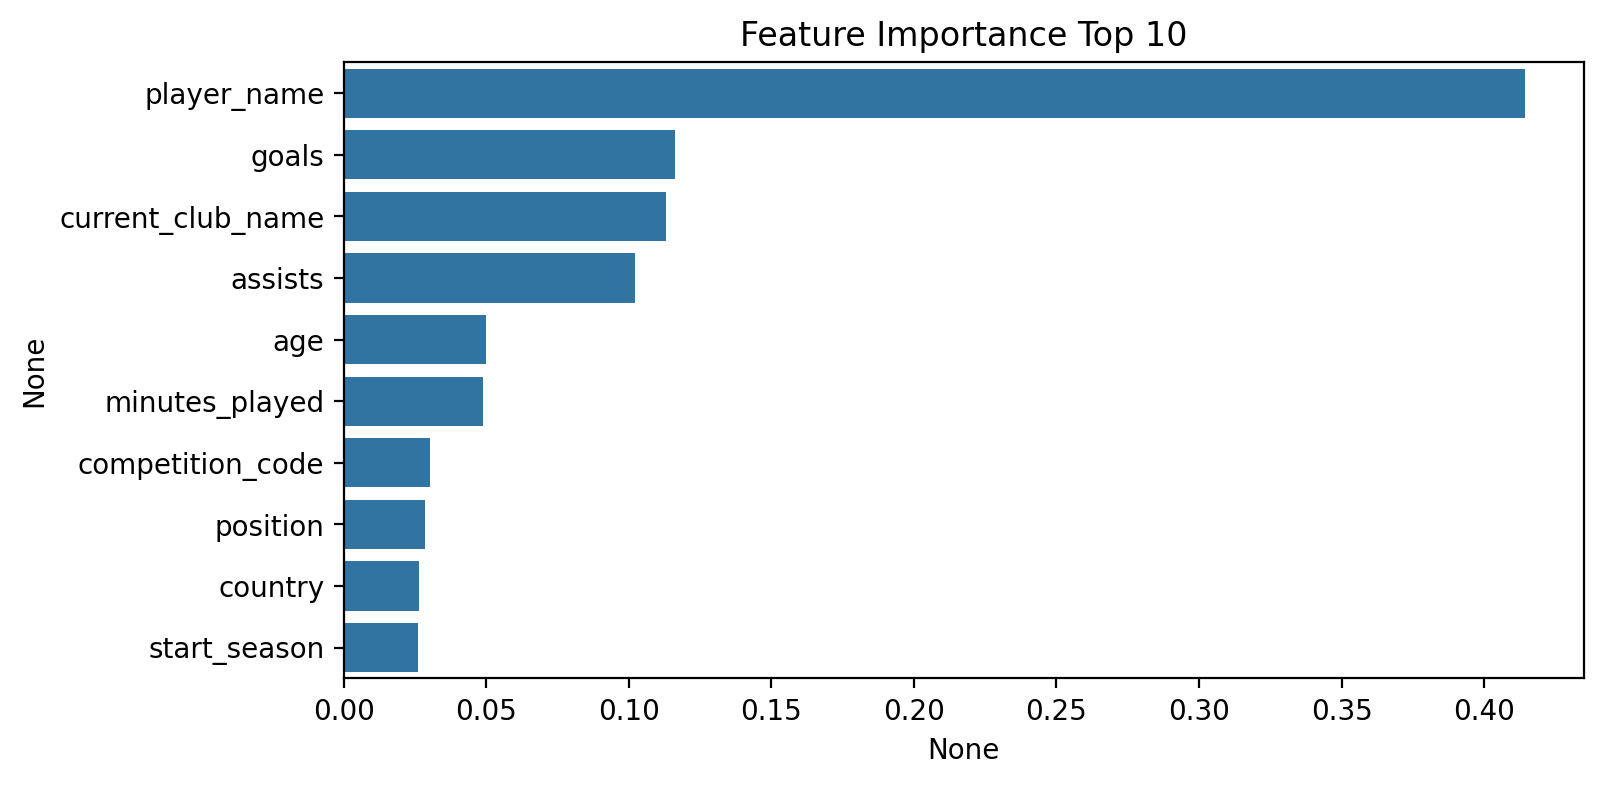

In [56]:
# feature importance 파악

# 배열형태로 반환
xgb_importance_values = xgb_optuna.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
xgb_series = pd.Series(xgb_importance_values, index = X_train.columns)
xgb_top10 = xgb_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=xgb_top10, y=xgb_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

### 모델로 예측한 test 값을 y_test 값과 비교

In [57]:
# test 데이터프레임 copy
test_copy = test.copy()

# xgb_optuna 모델로 예측한 X_test의 몸값을 담은 컬럼을 test_copy에 생성
test_copy["market_value_pred"] = xgb_optuna.predict(X_test)

In [58]:
# get_rmsle 함수 활용하여, 실제 몸값과 예측 몸값의 차이 RMSLE 계산한 컬럼 생성
test_copy['market_value_rmsle'] = test_copy.apply(lambda x:get_rmsle(x["market_value_per_season"], x["market_value_pred"]), axis=1)

In [59]:
test_copy = test_copy[['player_name', 'market_value_per_season', 'market_value_pred', 'market_value_rmsle',
                       'start_season', 'goals', 'assists', 'minutes_played',
                       'competition_code', 'age', 'position', 'current_club_name', 'country', 
                       'foot', 'height_in_cm']]

In [60]:
pd.options.display.float_format = '{:.2f}'.format

In [62]:
# RMSLE 값이 0.05 이하인 예측 값 확인
test_copy[test_copy.market_value_rmsle <= 0.05].sort_values(by="market_value_per_season", ascending=False).head(10)

,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
9663,Marcus Rashford,70000000.00,71826632.00,0.03,2023,7,3,1996,premier-league,26,Left Winger,Manchester United Football Club,England,right,185.00
2114,Bruno Fernandes,70000000.00,67870816.00,0.03,2023,4,6,2430,premier-league,29,Attacking Midfield,Manchester United Football Club,Portugal,right,179.00
10187,Matthijs de Ligt,65000000.00,63655416.00,0.02,2023,2,0,996,bundesliga,24,Centre-Back,FC Bayern München,Netherlands,right,189.00
3200,Darwin Núñez,65000000.00,67917272.00,0.04,2023,10,8,1572,premier-league,24,Centre-Forward,Liverpool Football Club,Uruguay,right,187.00
2739,Cole Palmer,45000000.00,46074188.00,0.02,2023,11,8,1746,premier-league,21,Attacking Midfield,Chelsea Football Club,England,left,189.00
11234,Nico Schlotterbeck,35000000.00,36631784.00,0.05,2023,2,0,2114,bundesliga,24,Centre-Back,Borussia Dortmund,Germany,left,191.00
3763,Donyell Malen,35000000.00,36226796.00,0.03,2023,11,2,1521,bundesliga,25,Right Winger,Borussia Dortmund,Netherlands,right,176.00
7864,Kalvin Phillips,28000000.00,28525434.00,0.02,2023,0,0,89,premier-league,28,Defensive Midfield,West Ham United Football Club,England,right,179.00
12270,Pierre-Emile Højbjerg,28000000.00,28646096.00,0.02,2023,0,0,979,premier-league,28,Defensive Midfield,Tottenham Hotspur Football Club,Denmark,right,185.00
7865,Kalvin Phillips,28000000.00,28559162.00,0.02,2023,0,0,271,premier-league,28,Defensive Midfield,West Ham United Football Club,England,right,179.00


In [63]:
# RMSLE 값이 2.7 이상인 예측 값 확인
# RMSLE 값 최대치 : 약 4.2

test_copy[test_copy.market_value_rmsle >= 2.7].sort_values(by="market_value_rmsle", ascending=False)

,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7206,Jordi Martín,50000.00,3251135.50,4.17,2023,0,0,476,laliga,23,Left Winger,Getafe Club de Fútbol S.A.D. Team Dubai,Spain,left,176.00
9978,Mateus Lusuardi,50000.00,1413135.75,3.34,2023,0,0,219,serie-a,20,Centre-Back,Frosinone Calcio S.r.l.,Brazil,left,190.00
14747,Tom Louchet,200000.00,4912846.00,3.20,2023,1,1,190,ligue-1,20,Central Midfield,Olympique Gymnaste Club Nice Côte d'Azur,France,both,178.00
6042,Isaac Romero,400000.00,9539936.00,3.17,2023,3,2,608,laliga,23,Centre-Forward,Sevilla Fútbol Club S.A.D.,Spain,left,184.00
15582,Yellu Santiago,100000.00,2343056.50,3.15,2023,0,0,172,laliga,19,Central Midfield,Getafe Club de Fútbol S.A.D. Team Dubai,Spain,right,192.00
1926,Bobby Clark,350000.00,7403893.50,3.05,2023,0,0,87,premier-league,19,Central Midfield,Liverpool Football Club,England,right,178.00
713,Alfie Gilchrist,300000.00,6311956.00,3.05,2023,0,0,18,premier-league,20,Centre-Back,Chelsea Football Club,England,right,183.00
14212,Steven Baseya,50000.00,1011258.81,3.01,2023,0,0,4,ligue-1,19,Centre-Back,Racing Club de Strasbourg Alsace,France,right,189.00
13496,Samu Omorodion,20000000.00,1241605.88,2.78,2023,1,0,82,laliga,19,Centre-Forward,Deportivo Alavés S.A.D.,Spain,right,193.00
7783,Jérémy Jacquet,50000.00,801898.31,2.77,2023,0,0,4,ligue-1,18,Centre-Back,Clermont Foot 63,France,right,188.00


In [64]:
test_copy[test_copy.current_club_name=="Arsenal Football Club"].sort_values("market_value_rmsle").head()

,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
14542,Thomas Partey,25000000.00,25290400.00,0.01,2023,0,0,277,premier-league,30,Defensive Midfield,Arsenal Football Club,Ghana,right,185.00
12648,Reiss Nelson,15000000.00,15507023.00,0.03,2023,0,0,182,premier-league,24,Right Winger,Arsenal Football Club,England,right,175.00
3850,Eddie Nketiah,35000000.00,33161128.00,0.05,2023,5,4,1044,premier-league,24,Centre-Forward,Arsenal Football Club,England,right,175.00
6361,Jakub Kiwior,25000000.00,27096482.00,0.08,2023,1,3,787,premier-league,24,Centre-Back,Arsenal Football Club,Poland,left,189.00
10728,Mohamed Elneny,4500000.00,3907198.75,0.14,2023,0,0,25,premier-league,31,Defensive Midfield,Arsenal Football Club,Egypt,right,179.00


In [65]:
test_copy[test_copy.current_club_name=="Tottenham Hotspur Football Club"].sort_values("market_value_rmsle").head()

,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
9348,Manor Solomon,18000000.00,17865012.00,0.01,2023,0,2,198,premier-league,24,Left Winger,Tottenham Hotspur Football Club,Israel,right,170.00
12270,Pierre-Emile Højbjerg,28000000.00,28646096.00,0.02,2023,0,0,979,premier-league,28,Defensive Midfield,Tottenham Hotspur Football Club,Denmark,right,185.00
11591,Oliver Skipp,15000000.00,16281629.00,0.08,2023,0,0,571,premier-league,23,Defensive Midfield,Tottenham Hotspur Football Club,England,right,175.00
13007,Rodrigo Bentancur,35000000.00,31765580.00,0.10,2023,1,0,510,premier-league,26,Central Midfield,Tottenham Hotspur Football Club,Uruguay,right,187.00
2194,Bryan Gil,16000000.00,18438536.00,0.14,2023,0,0,189,premier-league,23,Right Winger,Tottenham Hotspur Football Club,Spain,left,175.00
